<a href="https://colab.research.google.com/github/StepanTita/nano-BERT/blob/main/imdb_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! rm -rf nano-BERT
! git clone https://github.com/StepanTita/nano-BERT.git

Cloning into 'nano-BERT'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 10), reused 22 (delta 6), pack-reused 0
Receiving objects: 100% (27/27), 37.68 MiB | 23.16 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Updating files: 100% (10/10), done.


In [2]:
import sys

sys.path.append('/content/nano-BERT')

In [152]:
import math
import json
from collections import Counter

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from model import NanoBertForClassification
from tokenizer import WordTokenizer

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
data = None
with open('nano-BERT/data/imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

In [16]:
vocab = set()
for d in data:
    vocab |= set([w.lower() for w in d['text']])

In [12]:
test_data = None
with open('nano-BERT/data/imdb_test.json') as f:
   test_data = [json.loads(l) for l in f.readlines()]

In [91]:
def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')


class IMDBDataloader:
    def __init__(self, data, test_data, tokenizer, label_encoder, batch_size, val_frac=0.2):
        train_data, val_data = train_test_split(data, shuffle=True, random_state=42, test_size=val_frac)

        self.splits = {
            'train': [d['text'] for d in train_data],
            'test': [d['text'] for d in test_data],
            'val': [d['text'] for d in val_data]
        }

        self.labels = {
            'train': [d['label'] for d in train_data],
            'test': [d['label'] for d in test_data],
            'val': [d['label'] for d in val_data]
        }

        self.tokenized = {
            'train': [tokenizer(record).unsqueeze(0) for record in
                      tqdm(self.splits['train'], desc='Train Tokenization')],
            'test': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['test'], desc='Test Tokenization')],
            'val': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['val'], desc='Val Tokenization')],
        }

        self.encoded_labels = {
            'train': [label_encoder(label) for label in tqdm(self.labels['train'], desc='Train Label Encoding')],
            'test': [label_encoder(label) for label in tqdm(self.labels['test'], desc='Test Label Encoding')],
            'val': [label_encoder(label) for label in tqdm(self.labels['val'], desc='Val Label Encoding')],
        }

        self.curr_batch = 0
        self.batch_size = batch_size
        self.iterate_split = None

    def peek(self, split):
        return {
            'input_ids': self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
            'label_ids': self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
        }

    def take(self, split):
        batch = self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': batch,
            'label_ids': labels,
        }

    def peek_tokenized(self, split):
        return {
            'input_ids': torch.cat(
                self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dim=0),
            'label_ids': torch.tensor(
                self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dtype=torch.long),
        }

    def peek_index_tokenized(self, index, split):
        return {
            'input_ids': torch.cat(
                [self.tokenized[split][index]],
                dim=0),
            'label_ids': torch.tensor(
                [self.encoded_labels[split][index]],
                dtype=torch.long),
        }

    def peek_index(self, index, split):
        return {
            'input_ids': [self.splits[split][index]],
            'label_ids': [self.labels[split][index]],
        }

    def take_tokenized(self, split):
        batch = self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': torch.cat(batch, dim=0),
            'label_ids': torch.tensor(labels, dtype=torch.long),
        }

    def get_split(self, split):
        self.iterate_split = split
        return self

    def steps(self, split):
        return len(self.tokenized[split]) // self.batch_size

    def __iter__(self):
        self.reset()
        return self

    def __next__(self):
        if self.batch_size * self.curr_batch < len(self.splits[self.iterate_split]):
            return self.take_tokenized(self.iterate_split)
        else:
            raise StopIteration

    def reset(self):
        self.curr_batch = 0

In [92]:
NUM_EPOCHS = 50
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-2

In [93]:
tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
tokenizer

Tokenizer[vocab=101522,self.special_tokens=['[PAD]', '[CLS]', '[SEP]', '[UNK]'],self.sep=' ',self.max_seq_len=128]

In [94]:
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|██████████| 5000/5000 [00:00<00:00, 817380.05it/s]


In [30]:
bert = NanoBertForClassification(
    vocab_size=len(tokenizer.vocab),
    n_layers=1,
    n_heads=1,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=2
).to(device)
bert

NanoBertForClassification(
  (nano_bert): NanoBERT(
    (embedding): BertEmbeddings(
      (word_embeddings): Embedding(101522, 3)
      (pos_embeddings): Embedding(128, 3)
      (layer_norm): LayerNorm((3,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0): BertLayer(
          (layer_norm1): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
          (self_attention): BertSelfAttention(
            (heads): ModuleList(
              (0): BertAttentionHead(
                (query): Linear(in_features=3, out_features=3, bias=True)
                (key): Linear(in_features=3, out_features=3, bias=True)
                (values): Linear(in_features=3, out_features=3, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (proj): Linear(in_features=3, out_features=3, bias=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [32]:
count_parameters(bert)

305123

In [33]:
optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)

for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    for step, batch in enumerate(tqdm(dataloader.get_split('train'), total=dataloader.steps('train'))):
        logits = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)

        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'))):
        logits = bert(batch['input_ids'].to(device))

        probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss += loss.item()

    print()
    print(f'Train loss: {train_loss / dataloader.steps("train")} | Val loss: {val_loss / dataloader.steps("val")}')
    print(f'Train acc: {accuracy_score(train_labels, train_preds)} | Val acc: {accuracy_score(val_labels, val_preds)}')
    print(f'Train f1: {f1_score(train_labels, train_preds)} | Val f1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|██████████| 625/625 [00:03<00:00, 179.22it/s]
157it [00:00, 226.79it/s]                         



Train loss: 0.6946775919914245 | Val loss: 0.697885336402135
Train acc: 0.49975 | Val acc: 0.5128
Train f1: 0.4489121454144864 | Val f1: 0.5615550755939525
Epoch: 2


100%|██████████| 625/625 [00:02<00:00, 213.13it/s]
157it [00:00, 231.33it/s]                         



Train loss: 0.6938228719711304 | Val loss: 0.6978070239226023
Train acc: 0.4968 | Val acc: 0.5134
Train f1: 0.4699252080480354 | Val f1: 0.5666963490650044
Epoch: 3


100%|██████████| 625/625 [00:02<00:00, 214.08it/s]
157it [00:00, 221.90it/s]                         



Train loss: 0.6360874646663666 | Val loss: 0.482879482400723
Train acc: 0.60025 | Val acc: 0.771
Train f1: 0.6094093507254873 | Val f1: 0.7752698724239452
Epoch: 4


100%|██████████| 625/625 [00:03<00:00, 175.40it/s]
157it [00:00, 227.65it/s]                         



Train loss: 0.41674571437835695 | Val loss: 0.30955004854462087
Train acc: 0.8133 | Val acc: 0.8722
Train f1: 0.8126818501053477 | Val f1: 0.8739396330637207
Epoch: 5


100%|██████████| 625/625 [00:02<00:00, 219.67it/s]
157it [00:00, 228.46it/s]                         



Train loss: 0.31882440547943114 | Val loss: 0.21445655449627873
Train acc: 0.87005 | Val acc: 0.919
Train f1: 0.8695215623274262 | Val f1: 0.9197224975222993
Epoch: 6


100%|██████████| 625/625 [00:02<00:00, 216.70it/s]
157it [00:00, 226.83it/s]                         



Train loss: 0.2551265335738659 | Val loss: 0.14699756010668352
Train acc: 0.9025 | Val acc: 0.9476
Train f1: 0.9025097490250975 | Val f1: 0.9480982567353406
Epoch: 7


100%|██████████| 625/625 [00:04<00:00, 144.80it/s]
157it [00:01, 79.92it/s]                         



Train loss: 0.21430177025794983 | Val loss: 0.10424776242908616
Train acc: 0.91685 | Val acc: 0.9648
Train f1: 0.9167375957542683 | Val f1: 0.9649960222752586
Epoch: 8


100%|██████████| 625/625 [00:06<00:00, 90.14it/s] 
157it [00:01, 107.24it/s]                        



Train loss: 0.18894283285737037 | Val loss: 0.08273403256092794
Train acc: 0.92925 | Val acc: 0.974
Train f1: 0.9289051901723359 | Val f1: 0.9741447891805887
Epoch: 9


100%|██████████| 625/625 [00:04<00:00, 153.26it/s]
157it [00:00, 227.49it/s]                         



Train loss: 0.16347182873934507 | Val loss: 0.0721321125590923
Train acc: 0.94005 | Val acc: 0.9762
Train f1: 0.9398424564748382 | Val f1: 0.9763466507652553
Epoch: 10


100%|██████████| 625/625 [00:03<00:00, 192.10it/s]
157it [00:00, 226.71it/s]                         



Train loss: 0.14855054652318359 | Val loss: 0.05337068873968047
Train acc: 0.9455 | Val acc: 0.9826
Train f1: 0.9454017231015829 | Val f1: 0.9827140870256308
Epoch: 11


100%|██████████| 625/625 [00:03<00:00, 198.37it/s]
157it [00:01, 121.02it/s]                         



Train loss: 0.13528735290020705 | Val loss: 0.040416342296595804
Train acc: 0.9514 | Val acc: 0.9874
Train f1: 0.951150869434114 | Val f1: 0.9874826147426982
Epoch: 12


100%|██████████| 625/625 [00:04<00:00, 136.89it/s]
157it [00:01, 128.61it/s]                         



Train loss: 0.12300468230769038 | Val loss: 0.04034917937548389
Train acc: 0.95465 | Val acc: 0.9864
Train f1: 0.9543601871886478 | Val f1: 0.9864595778574273
Epoch: 13


100%|██████████| 625/625 [00:03<00:00, 189.31it/s]
157it [00:00, 221.35it/s]                         



Train loss: 0.136564461838454 | Val loss: 0.031879715568860635
Train acc: 0.95065 | Val acc: 0.988
Train f1: 0.9504940562772736 | Val f1: 0.9880763116057233
Epoch: 14


100%|██████████| 625/625 [00:03<00:00, 178.58it/s]
157it [00:00, 228.28it/s]                         



Train loss: 0.10824085210189223 | Val loss: 0.025623522473884244
Train acc: 0.96335 | Val acc: 0.9922
Train f1: 0.9632894275554666 | Val f1: 0.9922326229834695
Epoch: 15


100%|██████████| 625/625 [00:02<00:00, 220.66it/s]
157it [00:00, 231.87it/s]                         



Train loss: 0.10010190446265042 | Val loss: 0.028690180919977885
Train acc: 0.9654 | Val acc: 0.9902
Train f1: 0.9653722978382705 | Val f1: 0.9902526357668588
Epoch: 16


100%|██████████| 625/625 [00:02<00:00, 216.26it/s]
157it [00:00, 225.13it/s]                         



Train loss: 0.1000819265927188 | Val loss: 0.02731232593643467
Train acc: 0.965 | Val acc: 0.9882
Train f1: 0.9648417880462079 | Val f1: 0.9882773693622093
Epoch: 17


100%|██████████| 625/625 [00:03<00:00, 179.97it/s]
157it [00:00, 227.24it/s]                         



Train loss: 0.09591867245361209 | Val loss: 0.036234863599066816
Train acc: 0.9663 | Val acc: 0.9884
Train f1: 0.9662121515941448 | Val f1: 0.9884554140127388
Epoch: 18


100%|██████████| 625/625 [00:02<00:00, 219.51it/s]
157it [00:00, 226.26it/s]                         



Train loss: 0.08670226506311446 | Val loss: 0.019635474173693906
Train acc: 0.9692 | Val acc: 0.9944
Train f1: 0.9691320905993186 | Val f1: 0.9944356120826708
Epoch: 19


100%|██████████| 625/625 [00:03<00:00, 193.62it/s]
157it [00:00, 227.30it/s]                         



Train loss: 0.0874224642316578 | Val loss: 0.022266593680587202
Train acc: 0.96955 | Val acc: 0.9928
Train f1: 0.9693923707091521 | Val f1: 0.9928372463191404
Epoch: 20


100%|██████████| 625/625 [00:03<00:00, 179.02it/s]
157it [00:00, 216.17it/s]



Train loss: 0.0807699253115803 | Val loss: 0.030252550341127716
Train acc: 0.9723 | Val acc: 0.9906
Train f1: 0.9721971293787013 | Val f1: 0.9906430420067688
Epoch: 21


100%|██████████| 625/625 [00:02<00:00, 212.65it/s]
157it [00:00, 234.07it/s]                         



Train loss: 0.07801630572583526 | Val loss: 0.027725214464832486
Train acc: 0.9729 | Val acc: 0.9896
Train f1: 0.9727802330253114 | Val f1: 0.9896496815286624
Epoch: 22


100%|██████████| 625/625 [00:02<00:00, 219.03it/s]
157it [00:00, 229.06it/s]                         



Train loss: 0.07807612848952412 | Val loss: 0.021598032762808427
Train acc: 0.9729 | Val acc: 0.993
Train f1: 0.972755604704936 | Val f1: 0.9930348258706468
Epoch: 23


100%|██████████| 625/625 [00:03<00:00, 193.04it/s]
157it [00:00, 167.45it/s]                         



Train loss: 0.0765803251276724 | Val loss: 0.02474359039982888
Train acc: 0.97425 | Val acc: 0.992
Train f1: 0.9741374981168079 | Val f1: 0.99203187250996
Epoch: 24


100%|██████████| 625/625 [00:02<00:00, 212.19it/s]
157it [00:00, 226.36it/s]                         



Train loss: 0.0674460777502507 | Val loss: 0.027932001889171377
Train acc: 0.9767 | Val acc: 0.9904
Train f1: 0.9766111222646056 | Val f1: 0.9904306220095693
Epoch: 25


100%|██████████| 625/625 [00:02<00:00, 218.59it/s]
157it [00:00, 233.08it/s]                         



Train loss: 0.06378709034938365 | Val loss: 0.02822925907989534
Train acc: 0.97785 | Val acc: 0.991
Train f1: 0.9777420489373462 | Val f1: 0.991044776119403
Epoch: 26


100%|██████████| 625/625 [00:02<00:00, 213.28it/s]
157it [00:00, 163.01it/s]                         



Train loss: 0.05637666025590152 | Val loss: 0.01620328691075347
Train acc: 0.98065 | Val acc: 0.9948
Train f1: 0.9805771643663739 | Val f1: 0.9948269001193794
Epoch: 27


100%|██████████| 625/625 [00:03<00:00, 199.33it/s]
157it [00:00, 230.93it/s]                         



Train loss: 0.06059066775105894 | Val loss: 0.00686197874911625
Train acc: 0.9783 | Val acc: 0.9978
Train f1: 0.9782434329256066 | Val f1: 0.9978118161925601
Epoch: 28


100%|██████████| 625/625 [00:02<00:00, 218.57it/s]
157it [00:00, 227.64it/s]                         



Train loss: 0.06030484273659531 | Val loss: 0.007919717192262163
Train acc: 0.97845 | Val acc: 0.9978
Train f1: 0.9784316669168793 | Val f1: 0.9978100736611587
Epoch: 29


100%|██████████| 625/625 [00:02<00:00, 211.09it/s]
157it [00:00, 192.06it/s]                         



Train loss: 0.06414568589956034 | Val loss: 0.014642498099279831
Train acc: 0.9773 | Val acc: 0.9956
Train f1: 0.9772704515870632 | Val f1: 0.9956175298804782
Epoch: 30


100%|██████████| 625/625 [00:03<00:00, 188.46it/s]
157it [00:00, 226.00it/s]                         



Train loss: 0.05995850430801511 | Val loss: 0.011861251735843745
Train acc: 0.9794 | Val acc: 0.9968
Train f1: 0.9793607854924355 | Val f1: 0.9968190854870775
Epoch: 31


100%|██████████| 625/625 [00:02<00:00, 218.56it/s]
157it [00:00, 224.79it/s]                         



Train loss: 0.052755768998211716 | Val loss: 0.011636288493788855
Train acc: 0.9821 | Val acc: 0.9964
Train f1: 0.9820695181809075 | Val f1: 0.996420047732697
Epoch: 32


100%|██████████| 625/625 [00:03<00:00, 189.36it/s]
157it [00:00, 226.36it/s]                         



Train loss: 0.056212611166550776 | Val loss: 0.015069804769971084
Train acc: 0.98055 | Val acc: 0.9956
Train f1: 0.9805256570713391 | Val f1: 0.9956314535345513
Epoch: 33


100%|██████████| 625/625 [00:03<00:00, 180.35it/s]
157it [00:00, 228.07it/s]                         



Train loss: 0.053170061028189955 | Val loss: 0.011170427777286909
Train acc: 0.98175 | Val acc: 0.9964
Train f1: 0.9817253291944125 | Val f1: 0.996422893481717
Epoch: 34


100%|██████████| 625/625 [00:02<00:00, 218.31it/s]
157it [00:00, 228.45it/s]                         



Train loss: 0.05062883841176517 | Val loss: 0.008061128657060088
Train acc: 0.98245 | Val acc: 0.9972
Train f1: 0.982426275471887 | Val f1: 0.9972144846796659
Epoch: 35


100%|██████████| 625/625 [00:02<00:00, 211.91it/s]
157it [00:00, 220.40it/s]                         



Train loss: 0.051676455799653194 | Val loss: 0.00936164670052583
Train acc: 0.9812 | Val acc: 0.997
Train f1: 0.9811774128954747 | Val f1: 0.9970184853905785
Epoch: 36


100%|██████████| 625/625 [00:03<00:00, 171.57it/s]
157it [00:00, 220.23it/s]                         



Train loss: 0.05055475216165651 | Val loss: 0.006888682883772372
Train acc: 0.9832 | Val acc: 0.9974
Train f1: 0.9832016798320168 | Val f1: 0.9974160206718347
Epoch: 37


100%|██████████| 625/625 [00:02<00:00, 216.68it/s]
157it [00:00, 230.03it/s]                         



Train loss: 0.04979384461725131 | Val loss: 0.006598720343670441
Train acc: 0.98385 | Val acc: 0.998
Train f1: 0.983850807459627 | Val f1: 0.9980103461997613
Epoch: 38


100%|██████████| 625/625 [00:02<00:00, 218.31it/s]
157it [00:00, 231.57it/s]                         



Train loss: 0.0486451545862481 | Val loss: 0.00604949915801766
Train acc: 0.983 | Val acc: 0.9976
Train f1: 0.9830101938836697 | Val f1: 0.9976124154397135
Epoch: 39


100%|██████████| 625/625 [00:03<00:00, 164.03it/s]
157it [00:00, 203.49it/s]                         



Train loss: 0.04725086671181489 | Val loss: 0.007397282402519359
Train acc: 0.9825 | Val acc: 0.9984
Train f1: 0.9825069972011194 | Val f1: 0.9984095427435388
Epoch: 40


100%|██████████| 625/625 [00:03<00:00, 195.64it/s]
157it [00:00, 214.39it/s]                         



Train loss: 0.048260301039600745 | Val loss: 0.009222833307714423
Train acc: 0.98345 | Val acc: 0.9978
Train f1: 0.9834590974963769 | Val f1: 0.9978161604129442
Epoch: 41


100%|██████████| 625/625 [00:03<00:00, 204.39it/s]
157it [00:00, 215.67it/s]                         



Train loss: 0.0479048642416019 | Val loss: 0.002895569601978656
Train acc: 0.98385 | Val acc: 0.9996
Train f1: 0.9838443455209324 | Val f1: 0.9996023856858847
Epoch: 42


100%|██████████| 625/625 [00:03<00:00, 167.37it/s]
157it [00:00, 216.46it/s]                         



Train loss: 0.044991667462483745 | Val loss: 0.007732473929023306
Train acc: 0.98445 | Val acc: 0.9976
Train f1: 0.9844367712555673 | Val f1: 0.9976152623211446
Epoch: 43


100%|██████████| 625/625 [00:03<00:00, 207.30it/s]
157it [00:00, 207.92it/s]



Train loss: 0.049853145295055586 | Val loss: 0.004220167732105788
Train acc: 0.98335 | Val acc: 0.999
Train f1: 0.9833790865984526 | Val f1: 0.9990057665539869
Epoch: 44


100%|██████████| 625/625 [00:04<00:00, 131.97it/s]
157it [00:01, 88.19it/s]                         



Train loss: 0.048976188486604955 | Val loss: 0.005128358763310341
Train acc: 0.98255 | Val acc: 0.9982
Train f1: 0.9825473821073162 | Val f1: 0.9982103797971763
Epoch: 45


100%|██████████| 625/625 [00:06<00:00, 94.52it/s]
157it [00:00, 197.19it/s]                         



Train loss: 0.04440857763919048 | Val loss: 0.0036926450560340295
Train acc: 0.98545 | Val acc: 0.999
Train f1: 0.9854725175977235 | Val f1: 0.9990057665539869
Epoch: 46


100%|██████████| 625/625 [00:03<00:00, 174.15it/s]
157it [00:01, 151.47it/s]                         



Train loss: 0.038618998137908055 | Val loss: 0.005518019638400755
Train acc: 0.98725 | Val acc: 0.9994
Train f1: 0.9872544609386714 | Val f1: 0.999403459932392
Epoch: 47


100%|██████████| 625/625 [00:04<00:00, 143.11it/s]
157it [00:01, 142.28it/s]                         



Train loss: 0.04103855480768252 | Val loss: 0.004929090667246783
Train acc: 0.98535 | Val acc: 0.999
Train f1: 0.9853448707047466 | Val f1: 0.9990057665539869
Epoch: 48


100%|██████████| 625/625 [00:04<00:00, 128.08it/s]
157it [00:01, 108.85it/s]                         



Train loss: 0.04020545929386281 | Val loss: 0.00502962615640475
Train acc: 0.9858 | Val acc: 0.9992
Train f1: 0.9857857857857857 | Val f1: 0.9992047713717693
Epoch: 49


100%|██████████| 625/625 [00:06<00:00, 101.56it/s]
157it [00:01, 105.50it/s]



Train loss: 0.03828064977868926 | Val loss: 0.004576385549940964
Train acc: 0.9872 | Val acc: 0.999
Train f1: 0.9872063968015992 | Val f1: 0.9990057665539869
Epoch: 50


100%|██████████| 625/625 [00:06<00:00, 101.08it/s]
157it [00:01, 88.69it/s]                         



Train loss: 0.04152011936632916 | Val loss: 0.006749381812882441
Train acc: 0.98515 | Val acc: 0.998
Train f1: 0.9851314142678349 | Val f1: 0.9980119284294234


In [95]:
test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))

    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]

    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

782it [00:04, 179.40it/s]                         



Test loss: 0.3733398219947339
Test acc: 0.91248
Test f1: 0.9165777032179351


# Interpreting and visualizing the results

In [98]:
def get_attention_scores(model, input_ids):
    """
    This is just a wrapper to easily access attention heads of the last layer
    """

    mask = (input_ids > 0).unsqueeze(1).repeat(1, input_ids.size(1), 1)

    embed = model.nano_bert.embedding(input_ids)

    # can be any layer, and we can also control what to do with output for each layer (aggregate, sum etc.)
    layer = model.nano_bert.encoder.layers[-1]

    x = layer.layer_norm1(embed)

    B, seq_len, n_embed = x.shape

    # if have more than 1 head, or interested in more than 1 head output just add aggregation here
    head = layer.self_attention.heads[0]

    # this is just a part of the single head that does all the computations (same code is present in AttentionHead)
    q = head.query(x)
    k = head.key(x)
    v = head.values(x)

    weights = (q @ k.transpose(-2, -1)) / math.sqrt(n_embed)  # (B, Seq_len, Seq_len)
    weights = weights.masked_fill(mask == 0, -1e9)  # mask out not attended tokens

    scores = F.softmax(weights, dim=-1)

    return scores

In [96]:
test_dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=1)

Val Label Encoding: 100%|██████████| 5000/5000 [00:00<00:00, 1319461.43it/s]


In [149]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the A and B
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    plt.title(f'Attention scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [155]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(test_dataloader.splits['test']):
    if len(v) <= 16:
        examples_ids.append(i)
print(examples_ids)

[1959, 2939, 6394, 15789, 16349, 21487, 22019, 24588]


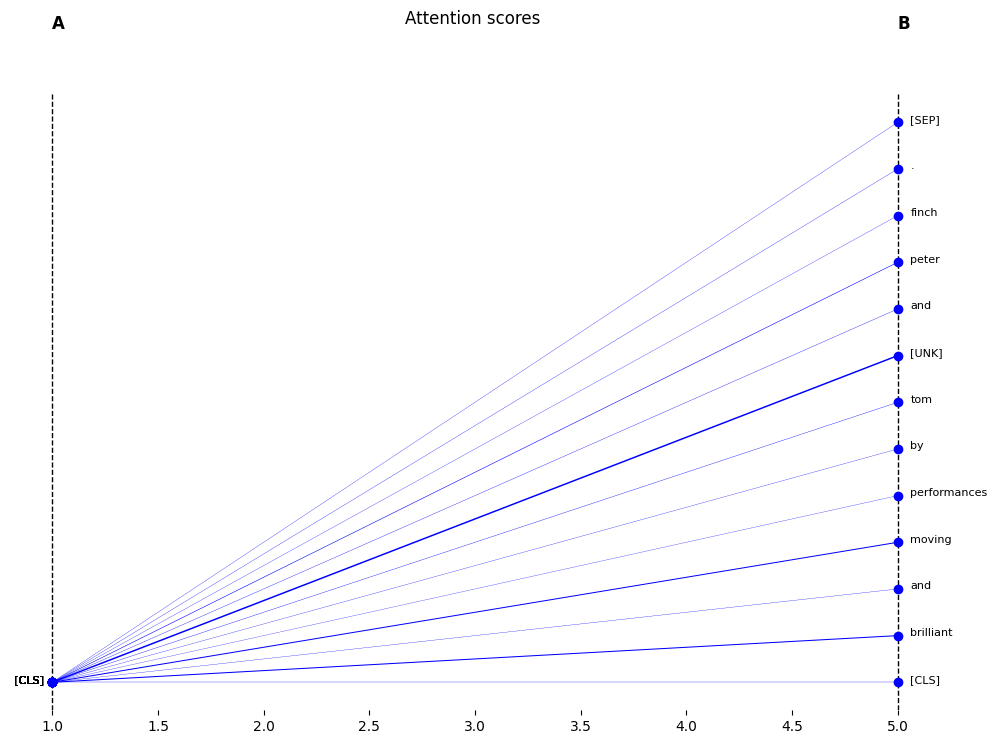

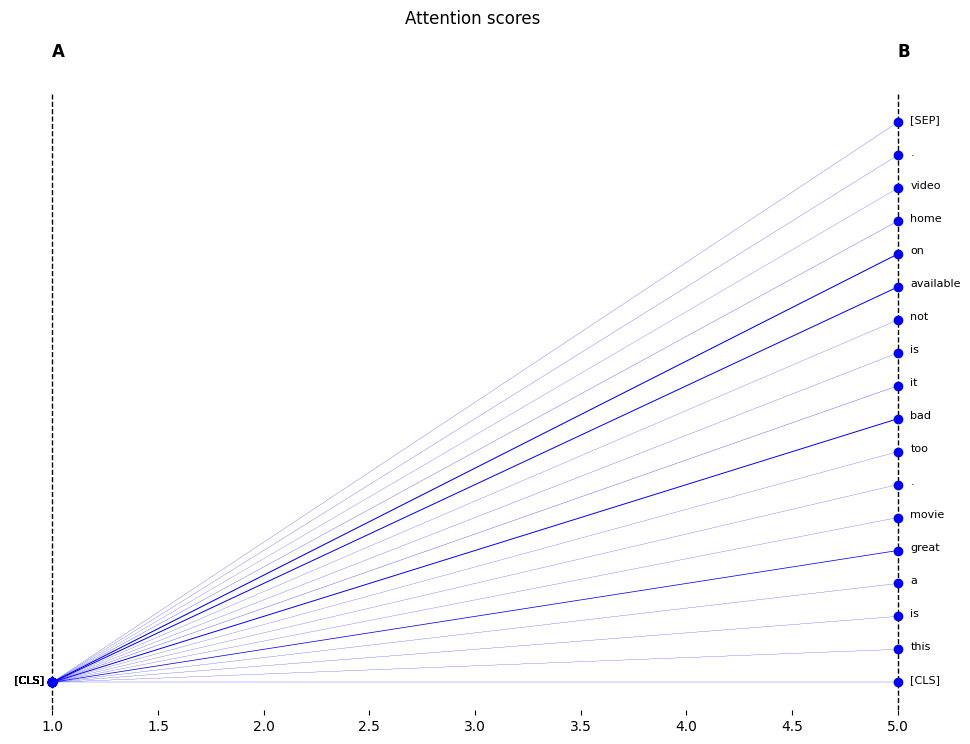

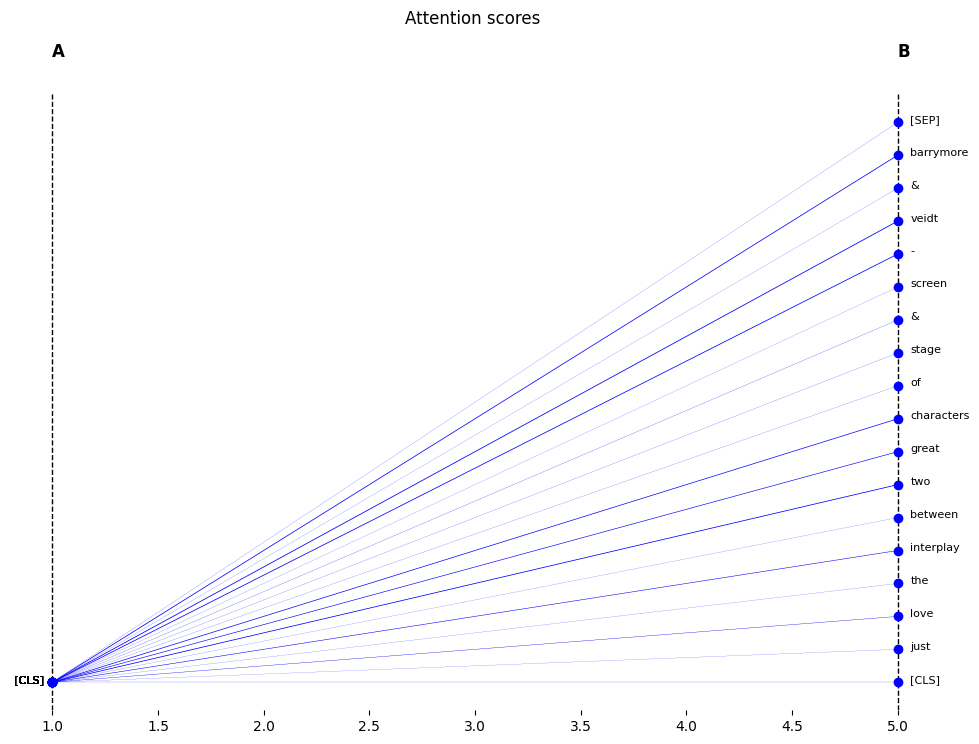

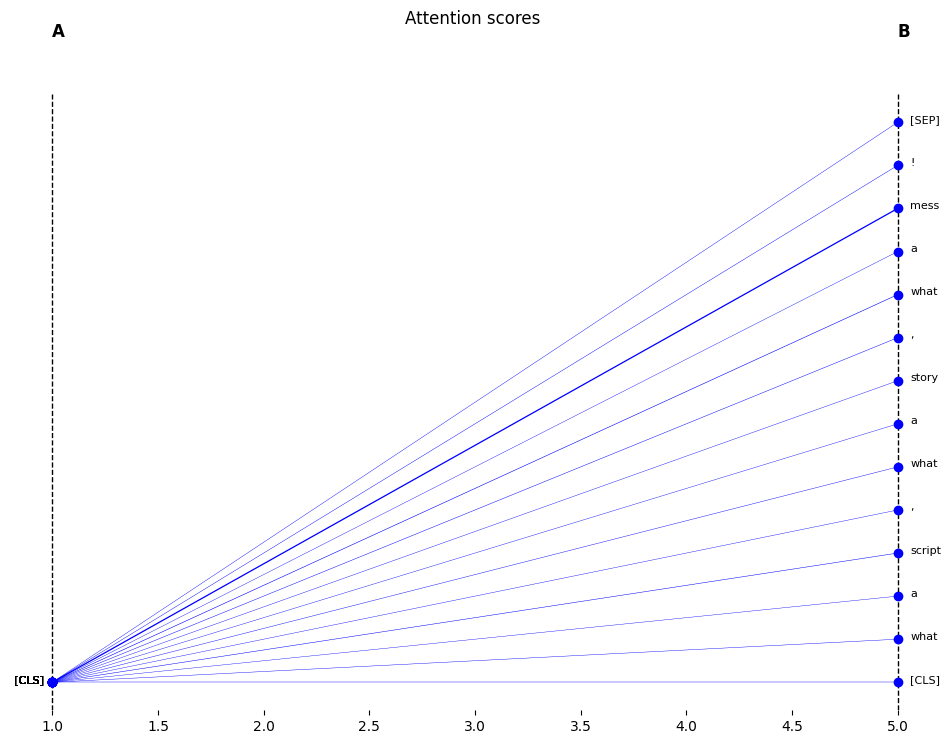

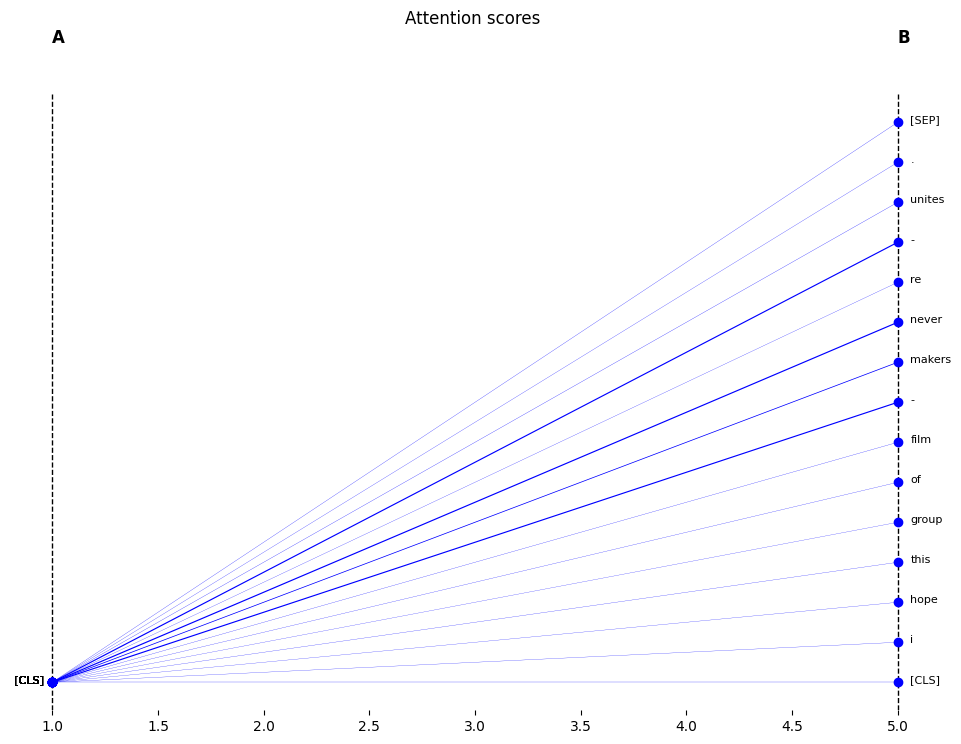

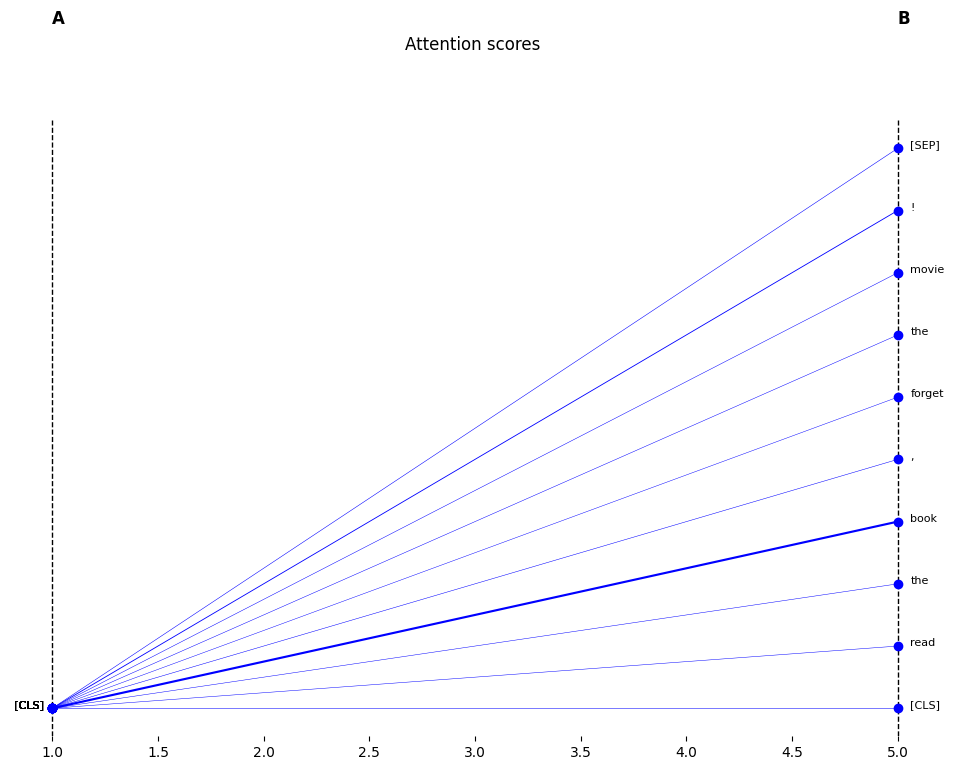

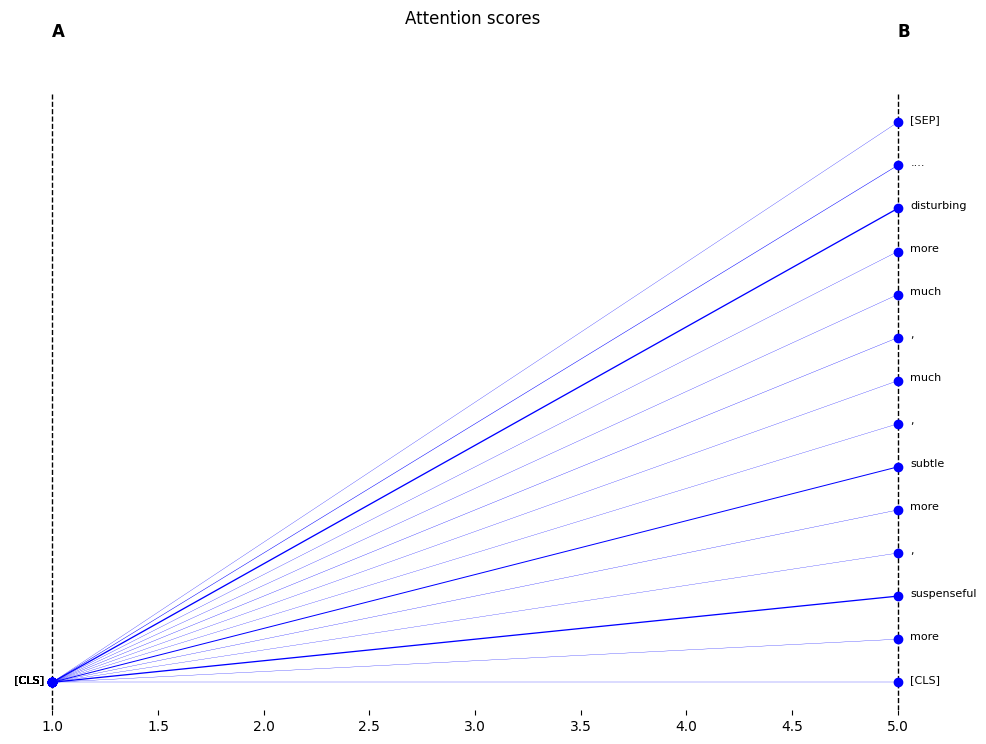

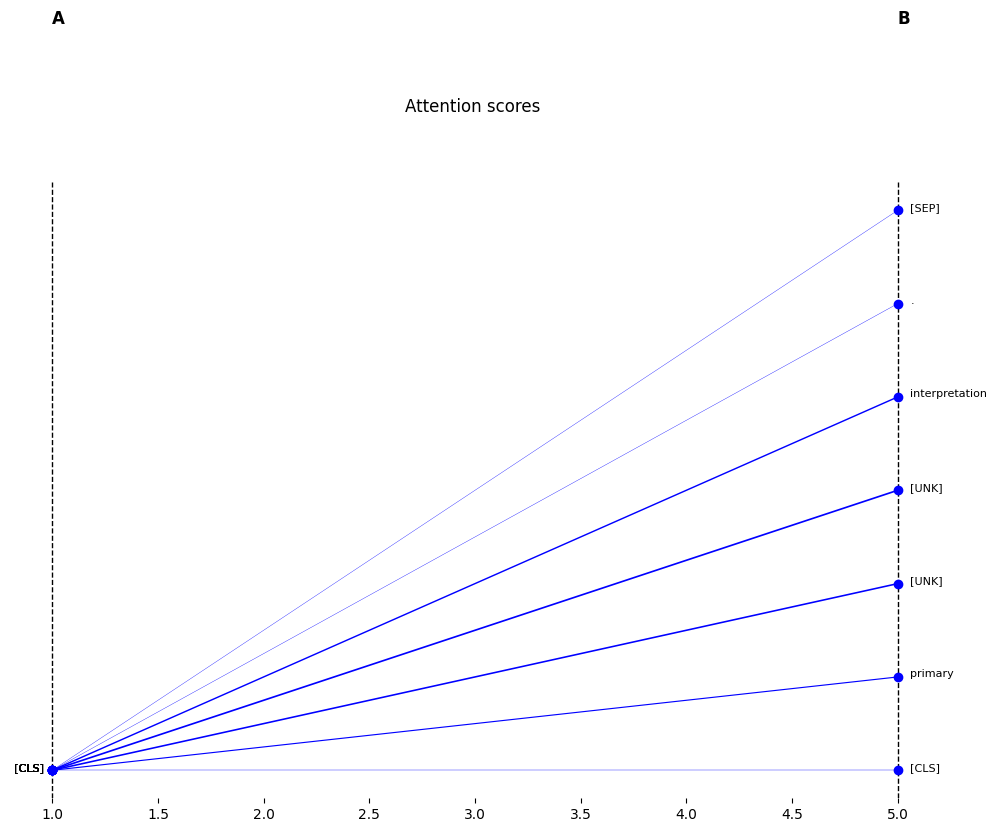

In [156]:
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    # calculate attention scores
    att_matrix = get_attention_scores(bert, test_tokenized_batch['input_ids'].to(device))[0, :seq_len, :seq_len]

    plot_parallel(att_matrix, tokens=tokens)

In [163]:
scatters = []
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    embed = bert.nano_bert.embedding(test_tokenized_batch['input_ids'].to(device))

    x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

    scatters.append(go.Scatter3d(
        x=x, y=y, z=z, mode='markers+text', name=f'Example: {sample_index}',
        text=tokens,
    ))

In [167]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Embeddings')
    ))
fig.show()

In [168]:
scatters = []
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if t != 0], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    embed = bert.nano_bert(test_tokenized_batch['input_ids'].to(device))

    x, y, z = embed[0, :seq_len, 0].detach().cpu().numpy(), embed[0, :seq_len, 1].detach().cpu().numpy(), embed[0, :seq_len, 2].detach().cpu().numpy()

    scatters.append(go.Scatter3d(
        x=x, y=y, z=z, mode='markers+text', name=f'Example: {sample_index}',
        text=tokens,
    ))

In [169]:
fig = go.Figure(
    data=scatters,
    layout=go.Layout(
        title=go.layout.Title(text='Raw Embeddings')
    ))
fig.show()